# Endocrine and Metabolism (PHAR1019)
# Experimental Design Workshop

## 1. Introduction

### 1.1. Preamble

This is a workbook file for the Endocrine and Metabolism (PHAR1019) Experimental Design workshop.

It contains interactive elements that are designed to help students explore fundamental concepts of experimental design.

The workbook is built with a programming language called Python. It can be interacted with without any previous knowledge of programming languages or coding using a web-browser interface called JupyterLite.

**You are not expected to write code. Focus on interpreting results and making design choices.**

### 1.2. Learning Objectives
- Explain parameters relevant for experiemntal design tasks
- Understand design choices for experimental design
- Critically interpret and evaluate data
- Develop an experimental design
- Develop familiarity with computational thinking

### 1.3. How to use this notebook
1. Access the workbook via this web-address: [https://mzelzer.github.io/EAM-PHAR1019-Experimental-Design-Workshop/](https://mzelzer.github.io/EAM-PHAR1019-Experimental-Design-Workshop/)
2. Select the *Python kernel* called **Pyodide** if prompted.
3. In the menu bar at the top, click **Run → Run All Cells**.
4. You are not expected to write Python from scratch — focus on interpreting results and making design choices.

### 1.4. Workshop Scenario
The workshop will use the experimental setup of determining glucose concentrations with a yeast assay that you will conduct in *Practical 1 - Measruement of Glucose Concentrations*.

This assay is based on the fact that under anaerobic conditions, yeast produces CO₂ at a rate proportional to the amount of glucose (and other carbohydrates!) present. Hence, glucose concentrations can be related to how fast the CO₂ pressure in a closed system increases.


## 2. Set-up

Before we start, we have to set up some functions and generate some synthetic data to work with.

### 2.1. Setting up the programming functions

Here, a series of codes is run to tell the software what programs (packages or libraries) are required to run the rest of the workbook. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Next, programs (functions) that are very specific to this workbook are defined. They are mostly code that help with plotting data.

This code is particularly long and has been hidden from view to keep the workbook tidy.

In [4]:

# ---- Pressure vs Time ----

def plot_pressure_timecourses(times_s, glucose_mg_ml, pressure, rep=0):
    P = pressure[rep]
    plt.figure()
    for j, g in enumerate(glucose_mg_ml):
        plt.plot(times_s, P[:, j], marker="o", label=f"{g:g} mg/mL")
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (mm H2O)")
    plt.title("Synthetic CO₂ pressure time-courses")
    plt.legend()
    plt.show()

### 2.1. Creating a synthetic dataset

In this workshop, we will work with synthetic data, i.e., data that has been made up; however, the data structure - the range of values and the variability - is informed by realistic model data. The nature of the data is therefore reflective of what you might encounter in a real experiment.

The code below generates this dataset. It is again hidden from view to keep the workbook tidy.

In [5]:

def generate_pressure_dataset(
    times_s=None,
    glucose_mg_ml=None,
    n_reps=1,
    seed=42,
    # ---- model knobs (you can tune these) ----
    p_max=1200.0,          # upper bound of pressure (mm H2O)
    tau=220.0,             # time constant for saturation (s)
    g_half=12.0,           # glucose half-saturation (mg/mL)
    hill=1.3,              # steepness of glucose effect
    lin_time=0.18,         # small linear drift term to avoid early flatness
    # ---- noise knobs ----
    noise_abs=8.0,         # baseline noise (mm H2O)
    noise_rel=0.035,       # relative noise (fraction of signal)
    # ---- missingness knobs ----
    missing_base=0.00,     # base probability of missing
    missing_pressure_scale=0.00025,  # increases missingness at high pressure
    missing_time_scale=0.00015,      # increases missingness at long times
):
    """
    Generate synthetic CO2 pressure data (mm H2O) as a function of time and initial glucose.
    
    Returns
    -------
    times_s : (T,) array
    glucose_mg_ml : (G,) array
    pressure : (n_reps, T, G) array with np.nan for missing values
    """
    rng = np.random.default_rng(seed)

    if times_s is None:
        # Match your practical scale (30 s to ~510 s, step 30 s)
        times_s = np.arange(30, 541, 30)
    else:
        times_s = np.asarray(times_s, dtype=float)

    if glucose_mg_ml is None:
        # Match your measured conditions, plus allow extension later if desired
        glucose_mg_ml = np.array([5, 10, 20, 40], dtype=float)
    else:
        glucose_mg_ml = np.asarray(glucose_mg_ml, dtype=float)

    T = times_s.size
    G = glucose_mg_ml.size

    # --- Glucose effect: saturating (diminishing returns), Hill-like ---
    # f_g in [0, 1)
    f_g = (glucose_mg_ml**hill) / (g_half**hill + glucose_mg_ml**hill)

    # --- Time effect: saturating growth + small drift ---
    # f_t in [0, ~1]
    f_t = 1.0 - np.exp(-times_s / tau)
    f_t = np.clip(f_t + lin_time * (times_s / times_s.max()), 0, 1.25)

    # Combine: pressure baseline structure
    # Shape (T, G)
    P_mean = p_max * np.outer(f_t, f_g)

    # Add mild curvature to mimic biology / inhibition at very high signal:
    # compress near the top end
    P_mean = P_mean * (1.0 - 0.10 * (P_mean / p_max)**2)
    P_mean = np.clip(P_mean, 0, p_max)

    # Replicates with heteroscedastic noise (abs + relative)
    pressure = np.empty((n_reps, T, G), dtype=float)

    for r in range(n_reps):
        eps = rng.normal(0.0, 1.0, size=(T, G))
        sigma = noise_abs + noise_rel * P_mean
        P = P_mean + sigma * eps

        # enforce monotonic-ish increase with time (optional, realism)
        # allow slight dips due to noise by not forcing strict monotonicity
        P = np.clip(P, 0, None)

        # Missingness: more likely at high pressure and long times
        p_miss = (
            missing_base
            + missing_pressure_scale * P
            + missing_time_scale * (times_s[:, None])
        )
        p_miss = np.clip(p_miss, 0, 0.35)  # cap so we don't wipe out data

        miss_mask = rng.uniform(0, 1, size=(T, G)) < p_miss

        # Also mimic your pattern: later timepoints missing for higher glucose
        # (soft rule; keep it probabilistic)
        high_g = glucose_mg_ml[None, :] >= 20
        late_t = times_s[:, None] >= 270
        miss_mask |= (rng.uniform(0, 1, size=(T, G)) < 0.10) & high_g & late_t

        P[miss_mask] = np.nan
        pressure[r] = P

    return times_s, glucose_mg_ml, pressure


# --- Example usage (quick sanity check) ---
if __name__ == "__main__":
    times, glucose, P = generate_pressure_dataset(n_reps=1, seed=1)
    # Print a small excerpt (first replicate)
    print("times:", times[:5], "...")
    print("glucose:", glucose)
    print("pressure (first 5 rows):")
    print(np.round(P[0, :5, :], 1))
    

times: [ 30  60  90 120 150] ...
glucose: [ 5. 10. 20. 40.]
pressure (first 5 rows):
[[ 43.3  81.4   nan 119.6]
 [ 84.9 142.4 196.2 265.4]
 [110.7 197.4 288.6 370.9]
 [124.6 240.  351.4 464.6]
 [158.8 281.1 407.7 522.5]]


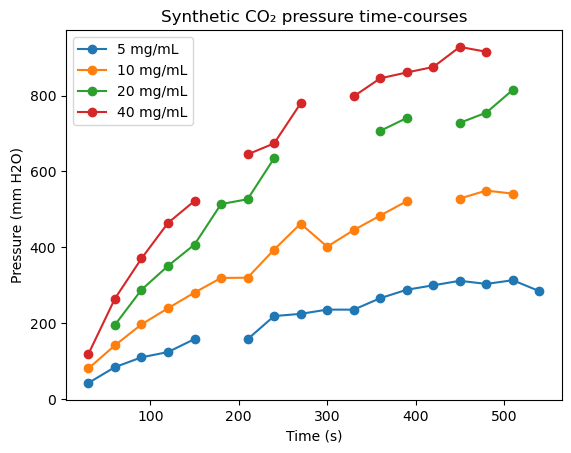

In [6]:
times, glucose, pressure = generate_pressure_dataset(n_reps=1, seed=1)
plot_pressure_timecourses(times, glucose, pressure)